# Registration

Correct for rigid/non-rigid movement

- Perfom motion-correction (rigid or piecewise-rigid) to eliminate movement in your movie.
- Run a grid-search across multiple sets of parameters.
- Use quality metrics to evaluate registration quality.

In [4]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import pandas as pd

import numpy as np
import tifffile
from matplotlib import pyplot as plt
import fastplotlib as fpl

import caiman as cm
import lbm_mc as mc
from lbm_mc.caiman_extensions.cnmf import cnmf_cache
from caiman.motion_correction import compute_metrics_motion_correction
import lbm_caiman_python as lcp

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

WGPU: enumerate_adapters() is deprecated, use enumerate_adapters_sync() instead.
WGPU: request_adapter() is deprecated, use request_adapter_sync() instead.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

## Data path and batch setup

We set 2 path variables:

1. `data_path` : input, path where you saved the output from the assembly step
- This will set the global `parent_raw_data_path`, so you can move the results anywhere you want as all results will be saved relative to this directory
2. `batch_path` : a results, can be anywhere you please, must end in `.pickle`

```{note}
This notebook assumes you saved scans as TIFF with `join_contiguous=True` so filenames are `plane_N.tiff`
The process for `join_contiguous=False` will differ and is not covered here.
```
In this demo we put our `batch_path` (which stores results) in raw directory, in its own folder.

This is helpful as you can move this folder anywhere you wish.

In [5]:
data_path = Path(r"C:\Users\RBO\lbm_data\processed")
batch_path = data_path / 'batch' / 'batch.pickle'

### Create or load a batch set

In [6]:
# Create or load a batch results file
# To overwrite (be very careful with this):
# batch_df = mc.create_batch(batch_path, remove_existing=True)

if not batch_path.exists():
    print(f'creating batch: {batch_path}')
    df = mc.create_batch(batch_path)
else:
    df = mc.load_batch(batch_path)

# tell mesmerize where the raw data is
mc.set_parent_raw_data_path(batch_path.parent.parent)

WindowsPath('C:/Users/RBO/lbm_data/processed')

In [7]:
tiff_files = [x for x in Path(data_path).glob('*.tif*')]
tiff_files[0]  # first file

WindowsPath('C:/Users/RBO/lbm_data/processed/plane_10_assembled.tiff')

### Load a data file to examine

In [8]:
file = tiff_files[1]
data = tifffile.memmap(file)
data.shape

(1729, 600, 576)

### View metadata

`lcp.get_metadata(filepath)` works on raw scanimage files and files processed through `lcp.save_as()`

In [9]:
metadata = lcp.get_metadata(file)
metadata

{'num_planes': 30,
 'num_frames': 1730,
 'fov': [150, 150],
 'num_rois': 4,
 'frame_rate': 9.60806,
 'pixel_resolution': [1.04, 1.0],
 'ndim': 3,
 'dtype': 'uint16',
 'size': 18648189000,
 'raw_height': 2478,
 'raw_width': 145,
 'tiff_pages': 51900,
 'roi_width_px': 144,
 'roi_height_px': 600,
 'sample_format': 'int16',
 'objective_resolution': 157.5}

In [10]:
dxy = metadata['pixel_resolution']
print(f"Pixel resolution: {dxy[0]} um/px, {dxy[1]} um/px")

Pixel resolution: 1.04 um/px, 1.0 um/px


In [11]:
# note this is only for a single ROI
fov = metadata['fov']
print(f"Field of View: {fov[0]}px, {fov[1]}px")

Field of View: 150px, 150px


In [12]:
fr = metadata['frame_rate']
print(f"Frame rate: {fr} Hz")

Frame rate: 9.60806 Hz


## Registration parameters

| Parameter               | Description                                                                                     | Value/Default                  |
|-------------------------|-------------------------------------------------------------------------------------------------|--------------------------------|
| `dxy`                  | Spatial resolution (pixel size in micrometers).                                                 | `dxy` (from metadata)           |
| `fr`                   | Frame rate of the video (frames per second).                                                    | `fr` (from metadata)            |
| `max_shifts`           | Maximum allowed rigid shift in pixels for motion correction.                                     | `(int(10/dxy), int(10/dxy))`   |
| `strides`              | Size of patches for motion correction.                                                          | `[48, 48]`                     |
| `overlaps`             | Overlap between patches for motion correction.                                                  | `[24, 24]`                     |
| `max_deviation_rigid`  | Maximum allowed deviation for patches relative to rigid shifts.                                  | `3`                            |
| `border_nan`           | How to handle border values during motion correction.                                            | `'copy'`                       |
| `pw_rigid`             | Flag indicating whether to perform piecewise rigid motion correction.                            | `False`                        |
| `gSig_filt`            | Size of the Gaussian filter for smoothing the motion correction process.                         | `(3, 3)`                       |
| `shifts_opencv`        | Flag to use bicubic interpolation for motion correction.                                         | `True`                         |

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

### Using metadata to assign parameter values

```{important}
The goal here is to get an approximate neuron size in microns.
This value is used as the basis of the `patch` and `max_shifts` parameters.
```

`plot_data_with_scalebars` will give you 3 images, at 5, 10 and 20 um.

You can use any summary images:

```python
# a single frame
plot_with_scalebars(data[0, :, :], np.mean(dxy))           

# mean projection image
plot_with_scalebars(np.mean(data, axis=0), np.mean(dxy))  

# maximum projection image
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))    
```

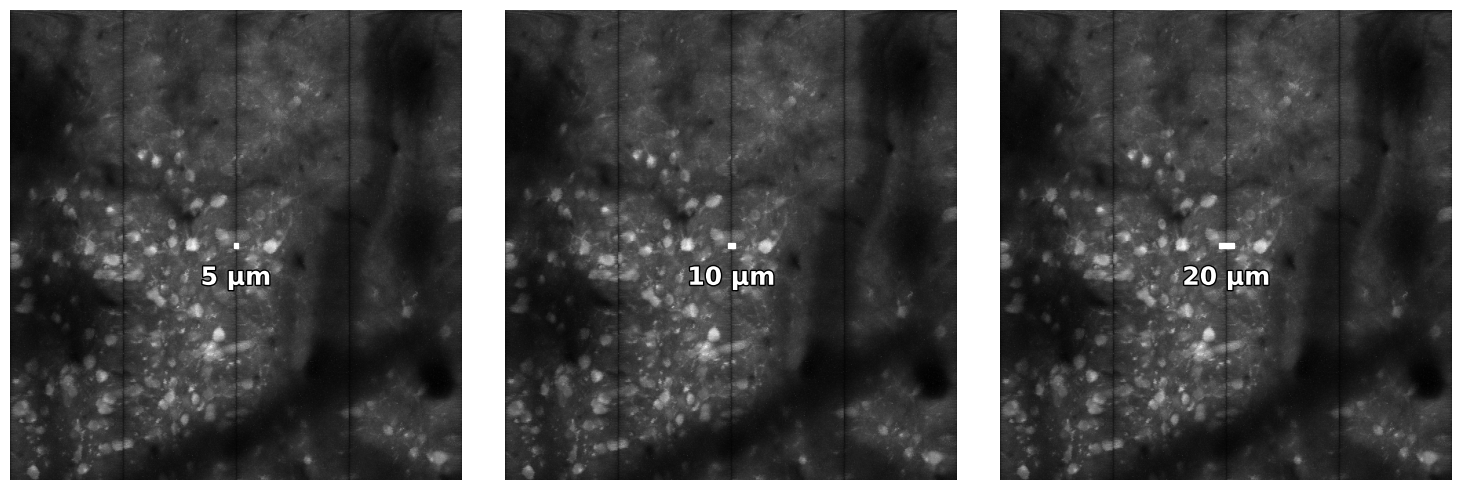

In [12]:
from lbm_caiman_python import plot_with_scalebars

# plot_with_scalebars(data[0, :, :], np.mean(dxy))
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))

### Scaling patches relative to neuron size

The `generate_patch_view` function divides the image into patches the same way CaImAn will do internally.

Increasing / decreasing the `target_patch_size` and `overlap_fraction` parameters to examine the effect of different stride/overlap values displayed in the title. 

```{tip}
We want each patch to have "landmarks" (neurons) to use for alignment, so we want at least a few full neurons for each patch.

For this reason, we use the `neuron_size` * `scale_factor` as our `target_patch_size`.

We want to **avoid** neurons occupying the inner regions of multiple neighboring patches.
```

In [13]:
neuron_size = 15    # in micron

# - value of 1 makes patches ~neuron sized
# - value of 2 makes patches ~2x neuron sized
# - the larger your neurons, the larger you want to make this number
scale_factor = 3 # must be > 0

overlap_fraction = 0.3  # 30% of the patch size will be overlap

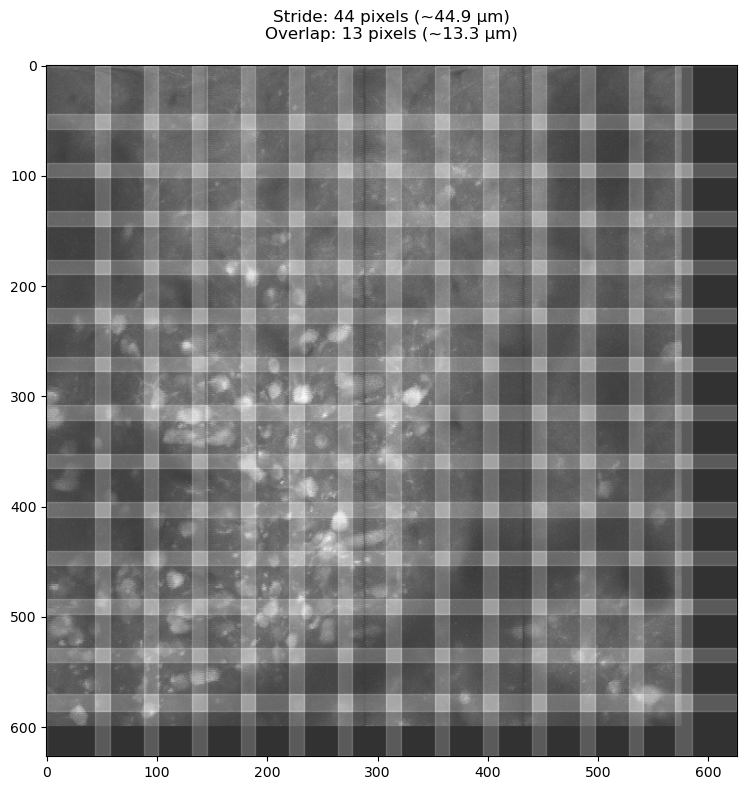

In [44]:
from lbm_caiman_python import generate_patch_view

target_patch_size=neuron_size*scale_factor

# this function assumes a square pixel resolution, so take the mean
fig, ax, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
plt.show()

In [13]:
print(f'stride : {stride_px}px\noverlap: {overlap_px}px')

stride : 44px
overlap: 13px


### Parameters from metadata

`lcp.params_from_metadata(metadata)` will calculate sensible defaults for registration (and segmentation).

Compare the strides / overlaps generated from the `generate_patch_view()` function. If they are significantly different,
we recommend you use the defaults for the first run, and tune with the values from your custom set overlap.

In [53]:
params = lcp.params_from_metadata(metadata)
params

Overlaps too small. Increasing to neuron diameter.


{'main': {'pw_rigid': True,
  'max_shifts': [10, 10],
  'strides': [62, 64],
  'overlaps': [7, 7],
  'min_mov': None,
  'gSig_filt': [0, 0],
  'max_deviation_rigid': 3,
  'border_nan': 'copy',
  'splits_els': 14,
  'upsample_factor_grid': 4,
  'use_cuda': False,
  'num_frames_split': 50,
  'niter_rig': 1,
  'is3D': False,
  'splits_rig': 14,
  'num_splits_to_process_rig': None,
  'fr': 9.60806,
  'dxy': [1.04, 1.0],
  'decay_time': 0.4,
  'p': 2,
  'nb': 3,
  'K': 20,
  'rf': 34,
  'stride': 7,
  'gSig': 7.5,
  'gSiz': (31.0, 31.0),
  'method_init': 'greedy_roi',
  'rolling_sum': True,
  'use_cnn': False,
  'ssub': 1,
  'tsub': 1,
  'merge_thr': 0.7,
  'bas_nonneg': True,
  'min_SNR': 1.4,
  'rval_thr': 0.8},
 'refit': True}

### Tune `gSig_filt` (high-pass-filter)

Use a spatial filter to highlight cells and eliminate low-frequency spatial information (i.e. blood-vessels)

In the below widget, move the slider at the bottom titled 'gSig_filt' to see if adding a gaussian blur can help highlight neurons and hide blood-vessels.

In [46]:
from ipywidgets import IntSlider, VBox
from caiman.motion_correction import high_pass_filter_space

slider_gsig_filt = IntSlider(value=1, min=1, max=33, step=1,  description="high-pass-filter (σ)")
funcs = {1: lambda frame: high_pass_filter_space(frame, (slider_gsig_filt.value, slider_gsig_filt.value))}

# input movie will be shown on left, filtered on right
iw_gs = fpl.ImageWidget(
    data=[data, data],
    frame_apply=funcs,
    names=["raw", f"filtered"],
    figure_kwargs={"size": (1200, 600)},
    cmap="gnuplot2"
)

iw_gs.figure["filtered"].set_title(f"filtered σ={slider_gsig_filt.value}")

def force_update(*args):
    # forces the images to update when the gSig_filt slider is moved
    iw_gs.current_index = iw_gs.current_index
    iw_gs.reset_vmin_vmax()
    iw_gs.figure["filtered"].set_title(f"filtered σ={slider_gsig_filt.value}")

iw_gs.reset_vmin_vmax()

slider_gsig_filt.observe(force_update, "value")

VBox([iw_gs.show(), slider_gsig_filt])

RFBOutputContext()

In [51]:
iw_gs.close(); slider_gsig_filt.close()

### Change a parameter

In [55]:
params['main']['gSig_filt'] = (2, 2)

## Single-plane registration

See the mesmerize-core [utility docs](https://mesmerize-core.readthedocs.io/en/latest/api/functions.html) for more information on batch creation.

We simple need to:

1. Add the batch item
2. Run the batch item

### Add an item to the batch

A "batch item" consists of:
* algorithm to run, `algo` 
    - currently: mcorr, cnmf, cnmfe
* input movie to run the algorithm on, `input_movie_path`
    - can be string or dataframe row
* parameters for the specified algorithm, `params`
* a name for you to keep track of things `item_name`
    - can be anything

In [21]:
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=file,
    params=params,
    item_name='mcorr',
)
df

algo item_name         input_movie_path  \
0  mcorr     mcorr  plane_11_assembled.tiff   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': [10, 10], 'strides': [62, 64], 'overlaps': [7, 7], 'min_mov': None, 'gSig_...   

  outputs           added_time ran_time algo_duration comments  \
0    None  2025-01-23T22:01:50     None          None     None   

                                   uuid  
0  22323919-7768-4d39-88ad-b0c3afff912f

### Run the batch item

```{note}
On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.
For this reason, on windows you need to reload the dataframe:
```
```python
df=df.caiman.reload_from_disk()
df
```

If you ever get errors like 

```python
TypeError: NoneType is not subscriptable
```
**This likely means you need to reload the dataframe**.

```{warning}
On windows, `df.iloc[i].caiman.run()` will sometimes stall if you run additional cells before it completes.
```

In [22]:
df.iloc[0].caiman.run()

Running 22323919-7768-4d39-88ad-b0c3afff912f with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


In [38]:
df=df.caiman.reload_from_disk()
df

algo item_name         input_movie_path  \
0  mcorr     mcorr  plane_11_assembled.tiff   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': [10, 10], 'strides': [62, 64], 'overlaps': [7, 7], 'min_mov': None, 'gSig_...   

                                                                                                                   outputs  \
0  {'mean-projection-path': '22323919-7768-4d39-88ad-b0c3afff912f/22323919-7768-4d39-88ad-b0c3afff912f_mean_projection....   

            added_time             ran_time algo_duration comments  \
0  2025-01-23T22:01:50  2025-01-23T22:03:07     71.93 sec     None   

                                   uuid  
0  22323919-7768-4d39-88ad-b0c3afff912f

### Check for errors in outputs

In the table header **outputs**, you should see 

```python
{'mean-projection-path': ...}
```
If you see instead:

```python
{'success': False, ...}
```

Run the below cell to evaluate the error message.

In [56]:
import pprint
pprint.pprint(df.iloc[0].outputs["traceback"])

None


### Preview results: side-by-side comparison

- `mesmerize-core` lets us easily retrieve a memory-mappable movie
- `fastplotlib` will efficiently display this movie using your GPU

[See the mesmerize-core motion-correction (mcorr) API](https://mesmerize-core.readthedocs.io/en/latest/api/mcorr.html).

In [57]:
# get the motion corrected movie memmap
mcorr_movie = df.iloc[0].mcorr.get_output()

# the input movie, note that we use `.caiman` here instead of `.mcorr`
input_movie = df.iloc[0].caiman.get_input_movie()

Its helpful to add a mean window and zoom into a cell to see if movement was corrected.

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='900.0px')
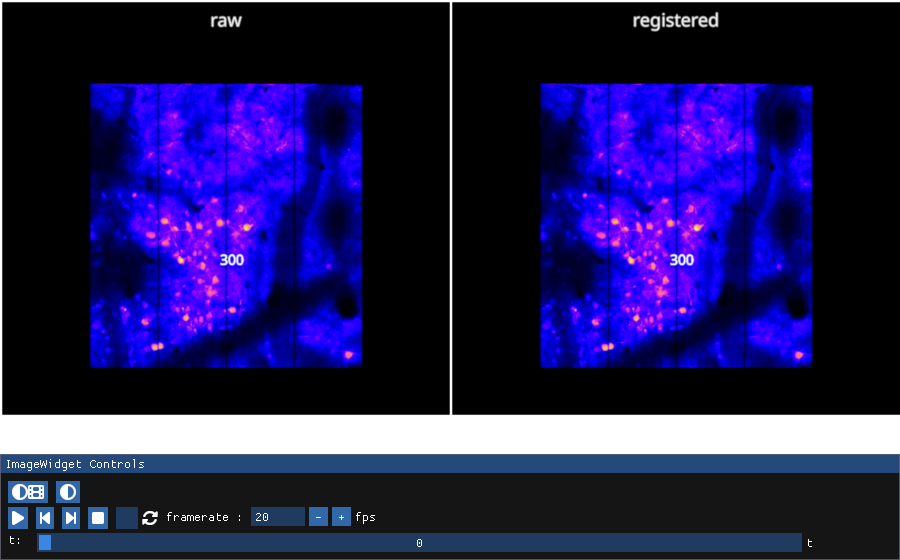

In [41]:
mcorr_iw = fpl.ImageWidget(
    data=[input_movie, mcorr_movie],
    names=['raw', 'registered'],
    cmap="gnuplot2",
    window_funcs={"t": (np.mean, 17)}, # window functions, can change to np.max, np.std, anything that operates on a timeseries
    figure_kwargs={"size": (900, 560)},
    histogram_widget=False, # helps keep plots close together
)
mcorr_iw.show()

In [42]:
mcorr_iw.close()

## Grid-search for best parameters

### `scale_factor` and `gSig_filt` 

If you still see non-rigid motion in your movie, we can try increasing the `scale_factor` to increase our patch-size or decrease it. 

More than likely you will want to decrease the scale factor to process more patches.

The patched graphs displayed show you what patches each of your movie will use.

```{tip}
The `item_name` parameter of `df.caiman.add_item()` is used to group similar batch results.
You should keep the `item_name` the same for grid search items.
```

In [ ]:
from copy import deepcopy

for scale in (1, 2, 4): # we started with a scale of 3
    for gSig in (0, 1, 2, 4): # very exaustive
        target_patch_size=neuron_size*scale
        overlap_fraction = .3 # keep overlap to 30% of patch size

        # _, _, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
        stride = int(target_patch_size / pixel_resolution)
        overlap = int(overlap_fraction * stride)
 
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(params)

        new_shift = int(np.ceil(overlap_px / 2))
        new_stride = int(np.ceil(stride_px))
        new_overlap = int(np.ceil(overlap_px))

        new_params["main"]["max_shifts"] = (new_shift, new_shift)
        new_params["main"]["strides"] = (new_stride, new_stride)
        new_params["main"]["overlaps"] = (new_overlap, new_overlap)
        new_params["main"]["overlaps"] = (new_overlap, new_overlap)
        new_params["main"]["gSig_filt"] = (gSig, gSig)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=file,
            params=new_params,
            item_name='mcorr',
        )

### View the parameter differences

```{tip}
We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`.

This shows the parameters that differ between our batch items.
```

In [61]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

max_shifts  overlaps   strides gSig_filt
0    [10, 10]    [7, 7]  [62, 64]    [0, 0]
1      (2, 2)    (4, 4)  (14, 14)    (0, 0)
2      (2, 2)    (4, 4)  (14, 14)    (1, 1)
3      (2, 2)    (4, 4)  (14, 14)    (2, 2)
4      (2, 2)    (4, 4)  (14, 14)    (4, 4)
5      (4, 4)    (8, 8)  (29, 29)    (0, 0)
6      (4, 4)    (8, 8)  (29, 29)    (1, 1)
7      (4, 4)    (8, 8)  (29, 29)    (2, 2)
8      (4, 4)    (8, 8)  (29, 29)    (4, 4)
9      (9, 9)  (17, 17)  (58, 58)    (0, 0)
10     (9, 9)  (17, 17)  (58, 58)    (1, 1)
11     (9, 9)  (17, 17)  (58, 58)    (2, 2)
12     (9, 9)  (17, 17)  (58, 58)    (4, 4)

### Use can also your own grid-search values.

For example:

``` python
from copy import deepcopy

for shifts in [2,32]:
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["pw_rigid"] = True
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=file,
            params=new_params,
            item_name='mcorr',  # filename of the movie, but can be anything
        )

df.caiman.reload_from_disk()
```

### Run all parameter sets

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [6]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

Running 8d6ff88a-12d4-4029-8b41-064b13d5ff43 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 958a6e01-8fb3-4ae5-b06b-623bce6782ae with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 58cd4cb9-e571-49a0-9c73-a33e6fdb83e2 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 1842685d-e421-423b-b872-3c76cb684fa4 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running f8d5343d-14a3-4872-89d6-6f862f9ce255 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running d6ccef75-5a5f-4d30-8dfa-2e1fe493fee1 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 9ad664bf-c22e-4ba6-ac2d-a7605933e2d2 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 90963ca2-a226-4503-8781-33fe09b40960 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 19d16022-e6e5-4bb6-b0fd-e9be9f7c4f9e with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 329e34f0-3c45-4427-820a-8000fc57c054 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


### Check for errors

In [7]:
# make sure everything works properly
# check for outputs {'success': False, ...
df = df.caiman.reload_from_disk()
df.outputs

0     {'mean-projection-path': '22323919-7768-4d39-88ad-b0c3afff912f/22323919-7768-4d39-88ad-b0c3afff912f_mean_projection....
1     {'mean-projection-path': 'efd3fcee-ba9e-46ff-826e-cffbef906411/efd3fcee-ba9e-46ff-826e-cffbef906411_mean_projection....
2     {'mean-projection-path': 'ab1e18e8-d860-408c-8588-a7995f542639/ab1e18e8-d860-408c-8588-a7995f542639_mean_projection....
3     {'mean-projection-path': '8d6ff88a-12d4-4029-8b41-064b13d5ff43/8d6ff88a-12d4-4029-8b41-064b13d5ff43_mean_projection....
4     {'mean-projection-path': '958a6e01-8fb3-4ae5-b06b-623bce6782ae/958a6e01-8fb3-4ae5-b06b-623bce6782ae_mean_projection....
5     {'mean-projection-path': '58cd4cb9-e571-49a0-9c73-a33e6fdb83e2/58cd4cb9-e571-49a0-9c73-a33e6fdb83e2_mean_projection....
6     {'mean-projection-path': '1842685d-e421-423b-b872-3c76cb684fa4/1842685d-e421-423b-b872-3c76cb684fa4_mean_projection....
7     {'mean-projection-path': 'f8d5343d-14a3-4872-89d6-6f862f9ce255/f8d5343d-14a3-4872-89d6-6f862f9ce255_mean_project

## Evaluate results

### Summary statistics

You can evaluate some basic statistics like mean, median, and percentiles of each item in your batch results. 

It is possible that parameter sets you used for your grid-search yield the same output movie (i.e. overlaps of (2, 2) and (3, 3) likely yield the same result).

You will want to compute registration statistics (correlation, optical flow) later which is computationally expensive, so it helps to limit the batch items you will use as input.

In [9]:
summary_df = lcp.get_summary_batch(df)
summary_df.head()

algo  Runs  Successful  Unsuccessful
0  mcorr    13          13             0
1   cnmf     0           0             0

#### Find the duplicates

Before calculating computationally intensive summary registration statistics like correlation and flow, we want to remove duplicates to avoid
unnessesary computaion.

`lcp.drop_duplicates` will iterate over your dataframe and drop any duplicate results.

In [11]:
# make sure to use the batch dataframe, not the summary dataframe
df = lcp.drop_duplicates(df)

Removing duplicate item efd3fcee-ba9e-46ff-826e-cffbef906411.
Removing duplicate item 58cd4cb9-e571-49a0-9c73-a33e6fdb83e2.
Removing duplicate item 9ad664bf-c22e-4ba6-ac2d-a7605933e2d2.


#### Reload our dataframe if you made a mistake

In [12]:
df = df.caiman.reload_from_disk()
df.head()

algo item_name         input_movie_path  \
0  mcorr     mcorr  plane_11_assembled.tiff   
1  mcorr     mcorr  plane_11_assembled.tiff   
2  mcorr     mcorr  plane_11_assembled.tiff   
3  mcorr     mcorr  plane_11_assembled.tiff   
4  mcorr     mcorr  plane_11_assembled.tiff   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': [10, 10], 'strides': [62, 64], 'overlaps': [7, 7], 'min_mov': None, 'gSig_...   
1  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   
2  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   
3  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   
4  {'main': {'pw_rigid': True, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'min_mov': None, 'gSig_fi...   

                                                                                                                   outputs  \
0  {'mean-projection-path': '22323919-7768-4d39-88ad-b0c3afff912f/22323919-7768-4d39-88ad-b0c3afff912f_mean_projection....   
1  {'mean-projection-path': 'ab1e18e8-d860-408c-8588-a7995f542639/ab1e18e8-d860-408c-8588-a7995f542639_mean_projection....   
2  {'mean-projection-path': '8d6ff88a-12d4-4029-8b41-064b13d5ff43/8d6ff88a-12d4-4029-8b41-064b13d5ff43_mean_projection....   
3  {'mean-projection-path': '958a6e01-8fb3-4ae5-b06b-623bce6782ae/958a6e01-8fb3-4ae5-b06b-623bce6782ae_mean_projection....   
4  {'mean-projection-path': '1842685d-e421-423b-b872-3c76cb684fa4/1842685d-e421-423b-b872-3c76cb684fa4_mean_projection....   

            added_time             ran_time algo_duration comments  \
0  2025-01-23T22:01:50  2025-01-23T22:03:07     71.93 sec     None   
1  2025-01-23T23:46:33  2025-01-23T23:51:40    126.03 sec     None   
2  2025-01-23T23:46:34  2025-01-24T10:34:48    124.27 sec     None   
3  2025-01-23T23:46:34  2025-01-24T10:36:55    126.95 sec     None   
4  2025-01-23T23:46:34  2025-01-24T10:39:52      89.0 sec     None   

                                   uuid  
0  22323919-7768-4d39-88ad-b0c3afff912f  
1  ab1e18e8-d860-408c-8588-a7995f542639  
2  8d6ff88a-12d4-4029-8b41-064b13d5ff43  
3  958a6e01-8fb3-4ae5-b06b-623bce6782ae  
4  1842685d-e421-423b-b872-3c76cb684fa4

### Evaluation metrics

| **Metric**       | **Description**                                           | **Higher or Lower is Better?** |
|------------------|----------------------------------------------------------|----------------------------------|
| **Correlations**  | How similar each frame is to a reference "template" frame. | **Higher is better** (closer to 1 means frames are more similar) |
| **Norms**         | The amount of movement or change in each frame.            | **Lower is better** (less movement indicates stability) |
| **Smoothness**    | How smooth/sharp/crisp the image appears.                     | **Higher is better** (crisper mean image) |
| **Flows**         | The direction and speed of pixel movement between frames.  | **Lower "better"** (less movement relative to mean image) |
| **Smoothness (correlations)** | How smooth the image of frame-to-frame correlations appears. | **Higher is better** (higher smoothness means sharper correlation map) |
| **Image Correlations** | Shows the local similarity of neighboring pixels in each frame. | **Higher is better** (higher local similarity means more consistent images) |

Many of these metrics are related. `Norms` is a measure of the stregnth of `flows` (which also include direction). `Smoothness` measures sharpness of edges which typically result in high`correlations` because individual pixels are located in the same location.

For more a technical discussion on these metrics, see [NoRMCorre's companion paper](https://www.sciencedirect.com/science/article/pii/S0165027017302753#sec0010) (section 2.2.1 - 2.2.4, 3.2.1 - 3.2.4).

#### Compute batch metrics

Feed your batch dataframe to `compute_batch_metrics` to compute each of these metrics and save them to disk.

This functiion will attempt to locate your raw data path to run evaluation metrics on the raw input-file for comparison.

Use `overwrite=False` to avoid re-calculating these values.

```{warning}
`compute_batch_metrics()` is a computationally intensive function. ~70s per batch item on a `600 x 576` pixel image with 1760 frames.
```
The returned `metrics_files` containes a list of paths to the saved metrics.

In [15]:
metrics_df = lcp.get_summary_mcorr(df)

Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  8.93it/s]


Computed metrics for raw data in 60.47 seconds.
Processing batch index 0...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  9.03it/s]


Computed metrics for batch index 0 in 60.22 seconds.
Processing batch index 1...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  8.91it/s]


Computed metrics for batch index 1 in 61.36 seconds.
Processing batch index 2...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  8.89it/s]


Computed metrics for batch index 2 in 60.87 seconds.
Processing batch index 3...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  8.98it/s]


Computed metrics for batch index 3 in 60.46 seconds.
Processing batch index 4...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  9.02it/s]


Computed metrics for batch index 4 in 60.60 seconds.
Processing batch index 5...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  8.93it/s]


Computed metrics for batch index 5 in 60.30 seconds.
Processing batch index 6...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  8.99it/s]


Computed metrics for batch index 6 in 60.51 seconds.
Processing batch index 7...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  9.01it/s]


Computed metrics for batch index 7 in 60.42 seconds.
Processing batch index 8...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  9.01it/s]


Computed metrics for batch index 8 in 60.29 seconds.
Processing batch index 9...


Optical flow: 100%|█████████████████████████████| 345/345 [00:38<00:00,  8.92it/s]


Computed metrics for batch index 9 in 60.55 seconds.


#### View numerical results

`lcp.get_summary_mcorr()` will use the resulting filepaths to load the **mean** metric statistic, along with the path to the metrics file.

This gives you an overview of the best results. The metric_path is needed to load larger arrays for plotting that don't performantly fit into a dataframe cell.

```{note}
batch_index = -1 for your *raw data*. This does not correspond to the 'last index', as it does with numpy slicing.
It is just convenient to avoid casting another data type like str/np.null.
```

In [17]:
metrics_df

mean_corr   mean_norm  crispness  \
0    0.889579  264.345490  19.149659   
1    0.917335  266.898865  19.722043   
2    0.903623  151.739716  19.741791   
3    0.906983   68.337738  20.577532   
4    0.907472  105.332611  20.506616   
5    0.899842  180.179504  19.350287   
6    0.903309   88.548859  20.409476   
7    0.905676   85.730988  20.597341   
8    0.897103  206.667816  19.136277   
9    0.902426  105.812897  20.490284   
10   0.905927   80.540215  20.706461   

                                        uuid  batch_index  \
0   raw_628bcc12-4d11-4c1f-aa64-cb47526867f4           -1   
1       22323919-7768-4d39-88ad-b0c3afff912f            0   
2       ab1e18e8-d860-408c-8588-a7995f542639            1   
3       8d6ff88a-12d4-4029-8b41-064b13d5ff43            2   
4       958a6e01-8fb3-4ae5-b06b-623bce6782ae            3   
5       1842685d-e421-423b-b872-3c76cb684fa4            4   
6       f8d5343d-14a3-4872-89d6-6f862f9ce255            5   
7       d6ccef75-5a5f-4d30-8dfa-2e1fe493fee1            6   
8       90963ca2-a226-4503-8781-33fe09b40960            7   
9       19d16022-e6e5-4bb6-b0fd-e9be9f7c4f9e            8   
10      329e34f0-3c45-4427-820a-8000fc57c054            9   

                                                                                                                metric_path  
0                                                            C:\Users\RBO\lbm_data\processed\plane_11_assembled_metrics.npz  
1   C:\Users\RBO\lbm_data\processed\batch\22323919-7768-4d39-88ad-b0c3afff912f\22323919-7768-4d39-88ad-b0c3afff912f-plan...  
2   C:\Users\RBO\lbm_data\processed\batch\ab1e18e8-d860-408c-8588-a7995f542639\ab1e18e8-d860-408c-8588-a7995f542639-plan...  
3   C:\Users\RBO\lbm_data\processed\batch\8d6ff88a-12d4-4029-8b41-064b13d5ff43\8d6ff88a-12d4-4029-8b41-064b13d5ff43-plan...  
4   C:\Users\RBO\lbm_data\processed\batch\958a6e01-8fb3-4ae5-b06b-623bce6782ae\958a6e01-8fb3-4ae5-b06b-623bce6782ae-plan...  
5   C:\Users\RBO\lbm_data\processed\batch\1842685d-e421-423b-b872-3c76cb684fa4\1842685d-e421-423b-b872-3c76cb684fa4-plan...  
6   C:\Users\RBO\lbm_data\processed\batch\f8d5343d-14a3-4872-89d6-6f862f9ce255\f8d5343d-14a3-4872-89d6-6f862f9ce255-plan...  
7   C:\Users\RBO\lbm_data\processed\batch\d6ccef75-5a5f-4d30-8dfa-2e1fe493fee1\d6ccef75-5a5f-4d30-8dfa-2e1fe493fee1-plan...  
8   C:\Users\RBO\lbm_data\processed\batch\90963ca2-a226-4503-8781-33fe09b40960\90963ca2-a226-4503-8781-33fe09b40960-plan...  
9   C:\Users\RBO\lbm_data\processed\batch\19d16022-e6e5-4bb6-b0fd-e9be9f7c4f9e\19d16022-e6e5-4bb6-b0fd-e9be9f7c4f9e-plan...  
10  C:\Users\RBO\lbm_data\processed\batch\329e34f0-3c45-4427-820a-8000fc57c054\329e34f0-3c45-4427-820a-8000fc57c054-plan...

#### Merge metrics results with added parameters used for grid-search

We used `df.caiman.get_param_diffs()` to get a list of parameters that differ between batch runs, to filter out the parameters common to each item.

We can add these values as columns to evaluate which parameters led to the desired metric by using `add_param_diffs` with either or both of the result tables we just calculated.

In [18]:
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])
results = lcp.concat_param_diffs(metrics_df, param_diffs)
results
# results.sort_values('mean_norm', ascending=True)

mean_corr   mean_norm  crispness gSig_filt   strides  overlaps max_shifts  \
0    0.889579  264.345490  19.149659      None      None      None       None   
1    0.917335  266.898865  19.722043    [0, 0]  [62, 64]    [7, 7]   [10, 10]   
2    0.903623  151.739716  19.741791    (1, 1)  (14, 14)    (4, 4)     (2, 2)   
3    0.906983   68.337738  20.577532    (2, 2)  (14, 14)    (4, 4)     (2, 2)   
4    0.907472  105.332611  20.506616    (4, 4)  (14, 14)    (4, 4)     (2, 2)   
5    0.899842  180.179504  19.350287    (1, 1)  (29, 29)    (8, 8)     (4, 4)   
6    0.903309   88.548859  20.409476    (2, 2)  (29, 29)    (8, 8)     (4, 4)   
7    0.905676   85.730988  20.597341    (4, 4)  (29, 29)    (8, 8)     (4, 4)   
8    0.897103  206.667816  19.136277    (1, 1)  (58, 58)  (17, 17)     (9, 9)   
9    0.902426  105.812897  20.490284    (2, 2)  (58, 58)  (17, 17)     (9, 9)   
10   0.905927   80.540215  20.706461    (4, 4)  (58, 58)  (17, 17)     (9, 9)   

    batch_index                                      uuid  \
0            -1  raw_628bcc12-4d11-4c1f-aa64-cb47526867f4   
1             0      22323919-7768-4d39-88ad-b0c3afff912f   
2             1      ab1e18e8-d860-408c-8588-a7995f542639   
3             2      8d6ff88a-12d4-4029-8b41-064b13d5ff43   
4             3      958a6e01-8fb3-4ae5-b06b-623bce6782ae   
5             4      1842685d-e421-423b-b872-3c76cb684fa4   
6             5      f8d5343d-14a3-4872-89d6-6f862f9ce255   
7             6      d6ccef75-5a5f-4d30-8dfa-2e1fe493fee1   
8             7      90963ca2-a226-4503-8781-33fe09b40960   
9             8      19d16022-e6e5-4bb6-b0fd-e9be9f7c4f9e   
10            9      329e34f0-3c45-4427-820a-8000fc57c054   

                                                                                                                metric_path  
0                                                            C:\Users\RBO\lbm_data\processed\plane_11_assembled_metrics.npz  
1   C:\Users\RBO\lbm_data\processed\batch\22323919-7768-4d39-88ad-b0c3afff912f\22323919-7768-4d39-88ad-b0c3afff912f-plan...  
2   C:\Users\RBO\lbm_data\processed\batch\ab1e18e8-d860-408c-8588-a7995f542639\ab1e18e8-d860-408c-8588-a7995f542639-plan...  
3   C:\Users\RBO\lbm_data\processed\batch\8d6ff88a-12d4-4029-8b41-064b13d5ff43\8d6ff88a-12d4-4029-8b41-064b13d5ff43-plan...  
4   C:\Users\RBO\lbm_data\processed\batch\958a6e01-8fb3-4ae5-b06b-623bce6782ae\958a6e01-8fb3-4ae5-b06b-623bce6782ae-plan...  
5   C:\Users\RBO\lbm_data\processed\batch\1842685d-e421-423b-b872-3c76cb684fa4\1842685d-e421-423b-b872-3c76cb684fa4-plan...  
6   C:\Users\RBO\lbm_data\processed\batch\f8d5343d-14a3-4872-89d6-6f862f9ce255\f8d5343d-14a3-4872-89d6-6f862f9ce255-plan...  
7   C:\Users\RBO\lbm_data\processed\batch\d6ccef75-5a5f-4d30-8dfa-2e1fe493fee1\d6ccef75-5a5f-4d30-8dfa-2e1fe493fee1-plan...  
8   C:\Users\RBO\lbm_data\processed\batch\90963ca2-a226-4503-8781-33fe09b40960\90963ca2-a226-4503-8781-33fe09b40960-plan...  
9   C:\Users\RBO\lbm_data\processed\batch\19d16022-e6e5-4bb6-b0fd-e9be9f7c4f9e\19d16022-e6e5-4bb6-b0fd-e9be9f7c4f9e-plan...  
10  C:\Users\RBO\lbm_data\processed\batch\329e34f0-3c45-4427-820a-8000fc57c054\329e34f0-3c45-4427-820a-8000fc57c054-plan...

#### Optical Flow

Optical flow measures the movement of a pixel between two consecutive frames.

Movement is illustrated as brighter values, with the hue (color) illustrating the direction of movement.

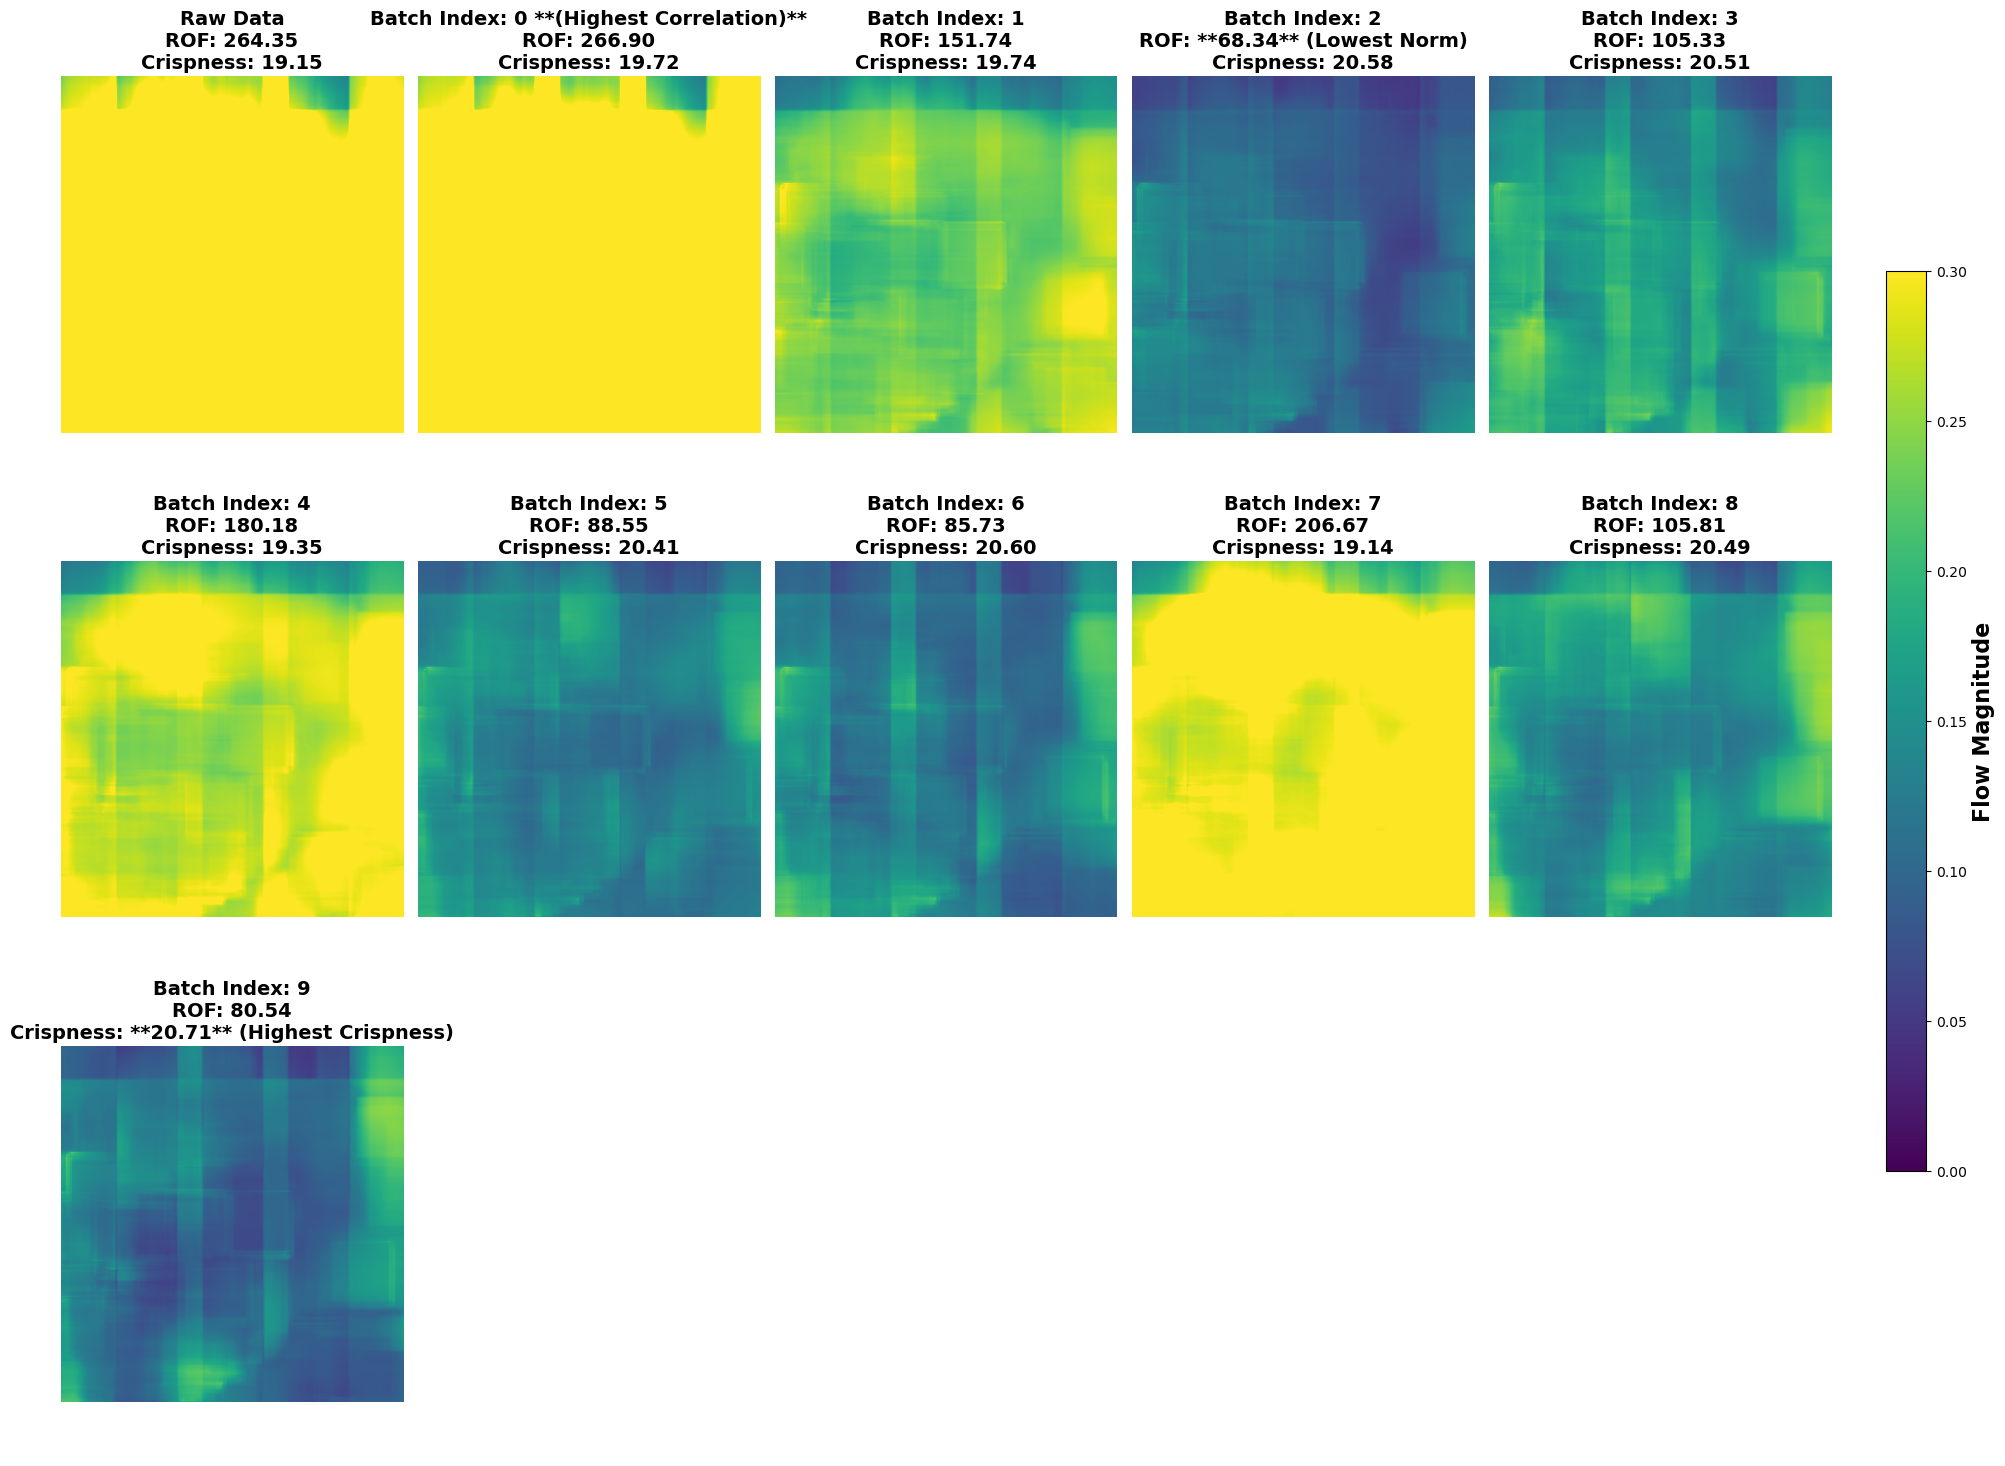

In [19]:
import lbm_caiman_python as lcp

# This will plot all batches.
lcp.plot_optical_flows(results, max_columns=5)

#### Plot residual flows and correlations 

- `lcp.plot_residual_flows()` and `lcp.plot_correlations()` will first **sort your results by the corresponding metric**.
- Use the `num_batches` argument to display just the **best results** and avoid cluttering your figure
- Increase the number of batches to see groupings
- You can then see the batch index in the key to query back to your metrics results and see if any parameters led to metrics being grouped

##### With many batches

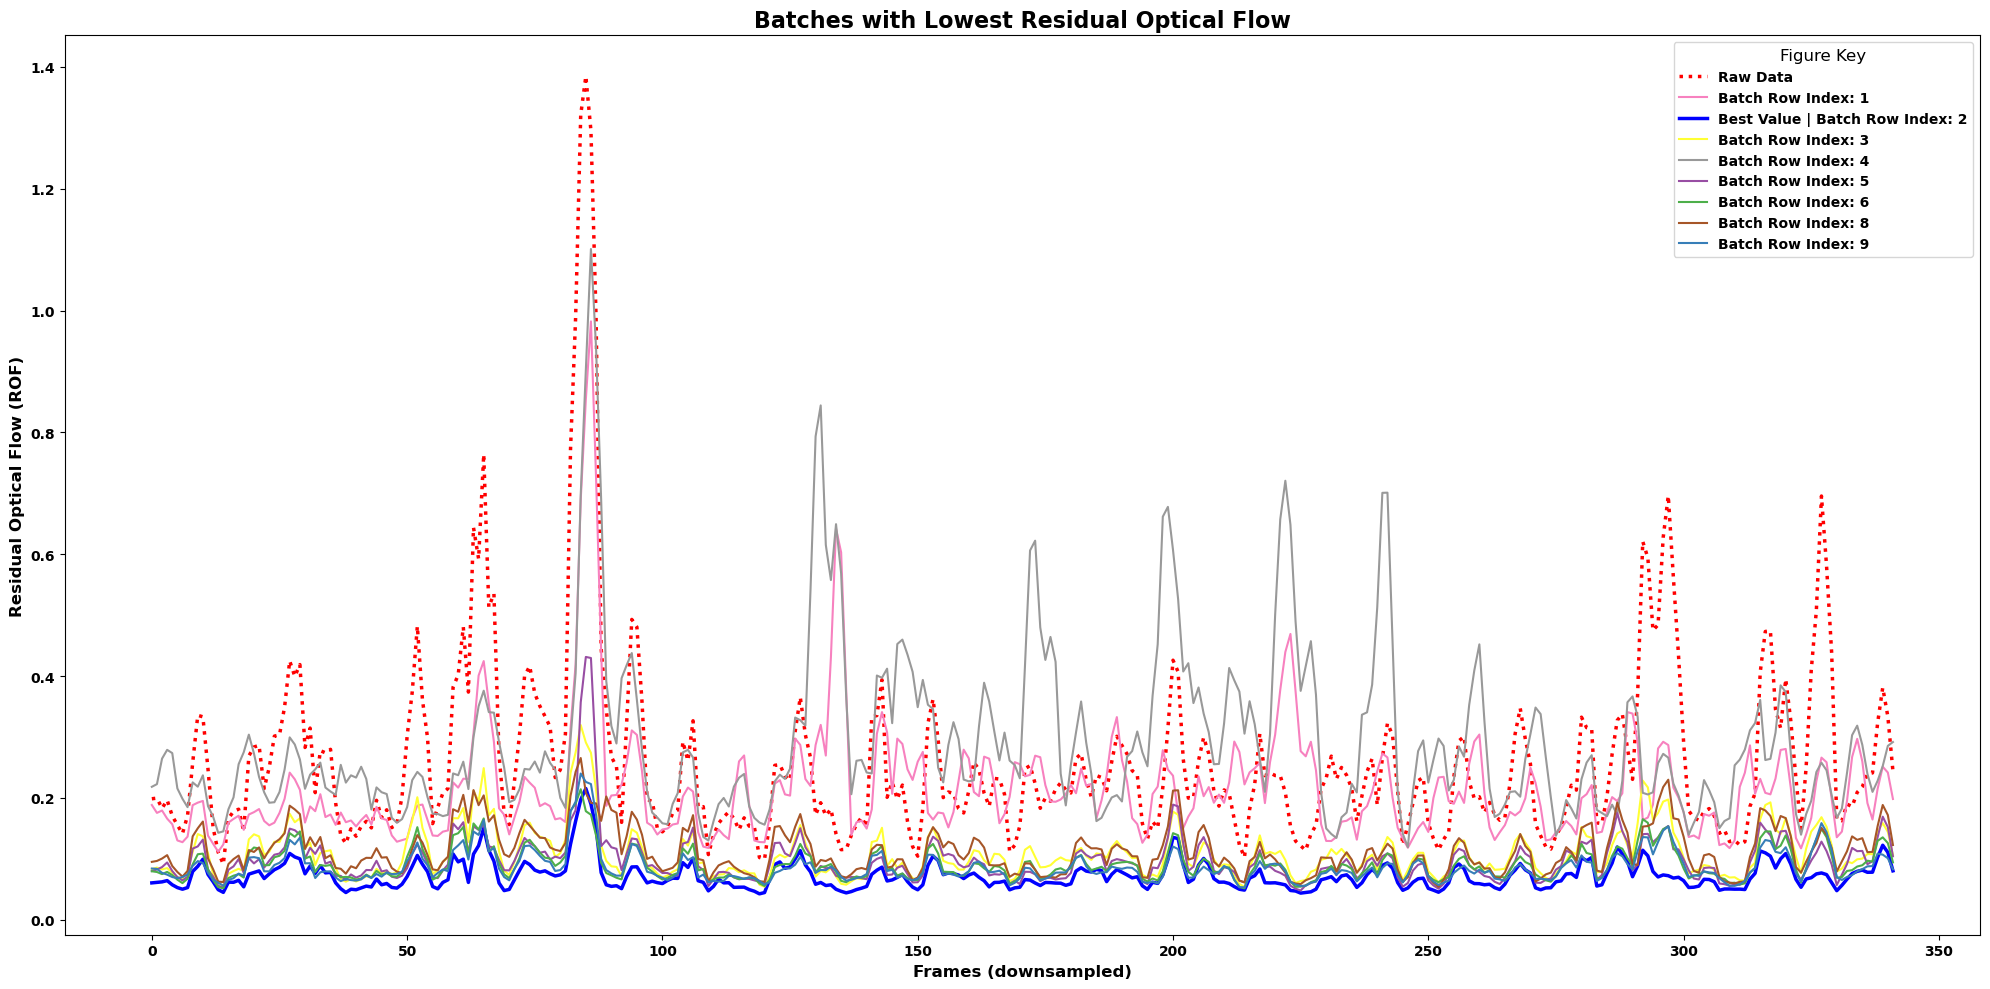

In [20]:
lcp.plot_residual_flows(results, num_batches=8, smooth=True, winsize=3)

##### With only 2 batches, no smoothing

Now, show only the best 2 batch runs as determiend by residual optical flow without smoothing

```{note}
No matter how many batches you decide to include, the raw data will be displayed as well in a dotted line.

If your raw data **is the best result**, it will be a blue dotted line.
```

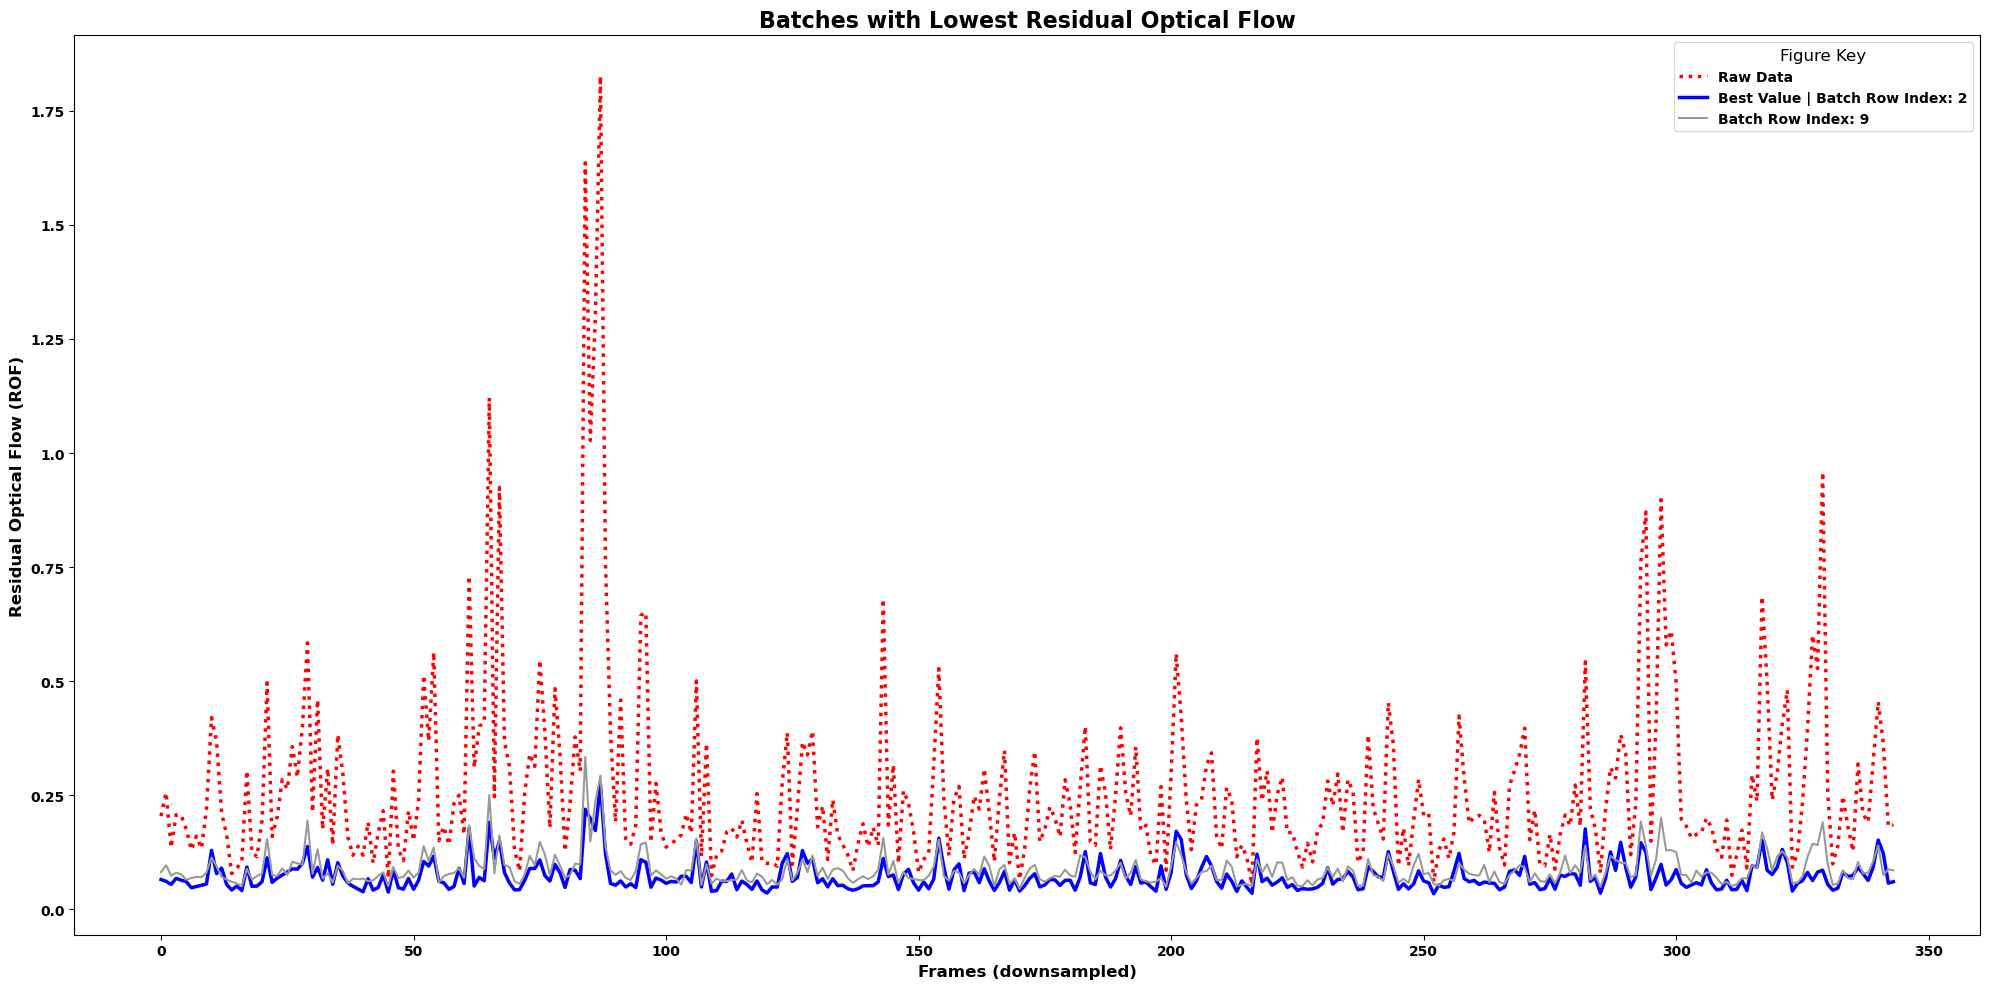

In [21]:
lcp.plot_residual_flows(results, num_batches=2, smooth=False)

Notice how there are many batch results that seem to align perfectly with the "best" result.

Correlation here is defined as the mean pixel correlation for each frame to the correlation image **within each movie**.

It is possible to increase pixel-correlations and still have poor registration. Correlation and flow metrics should be used together.

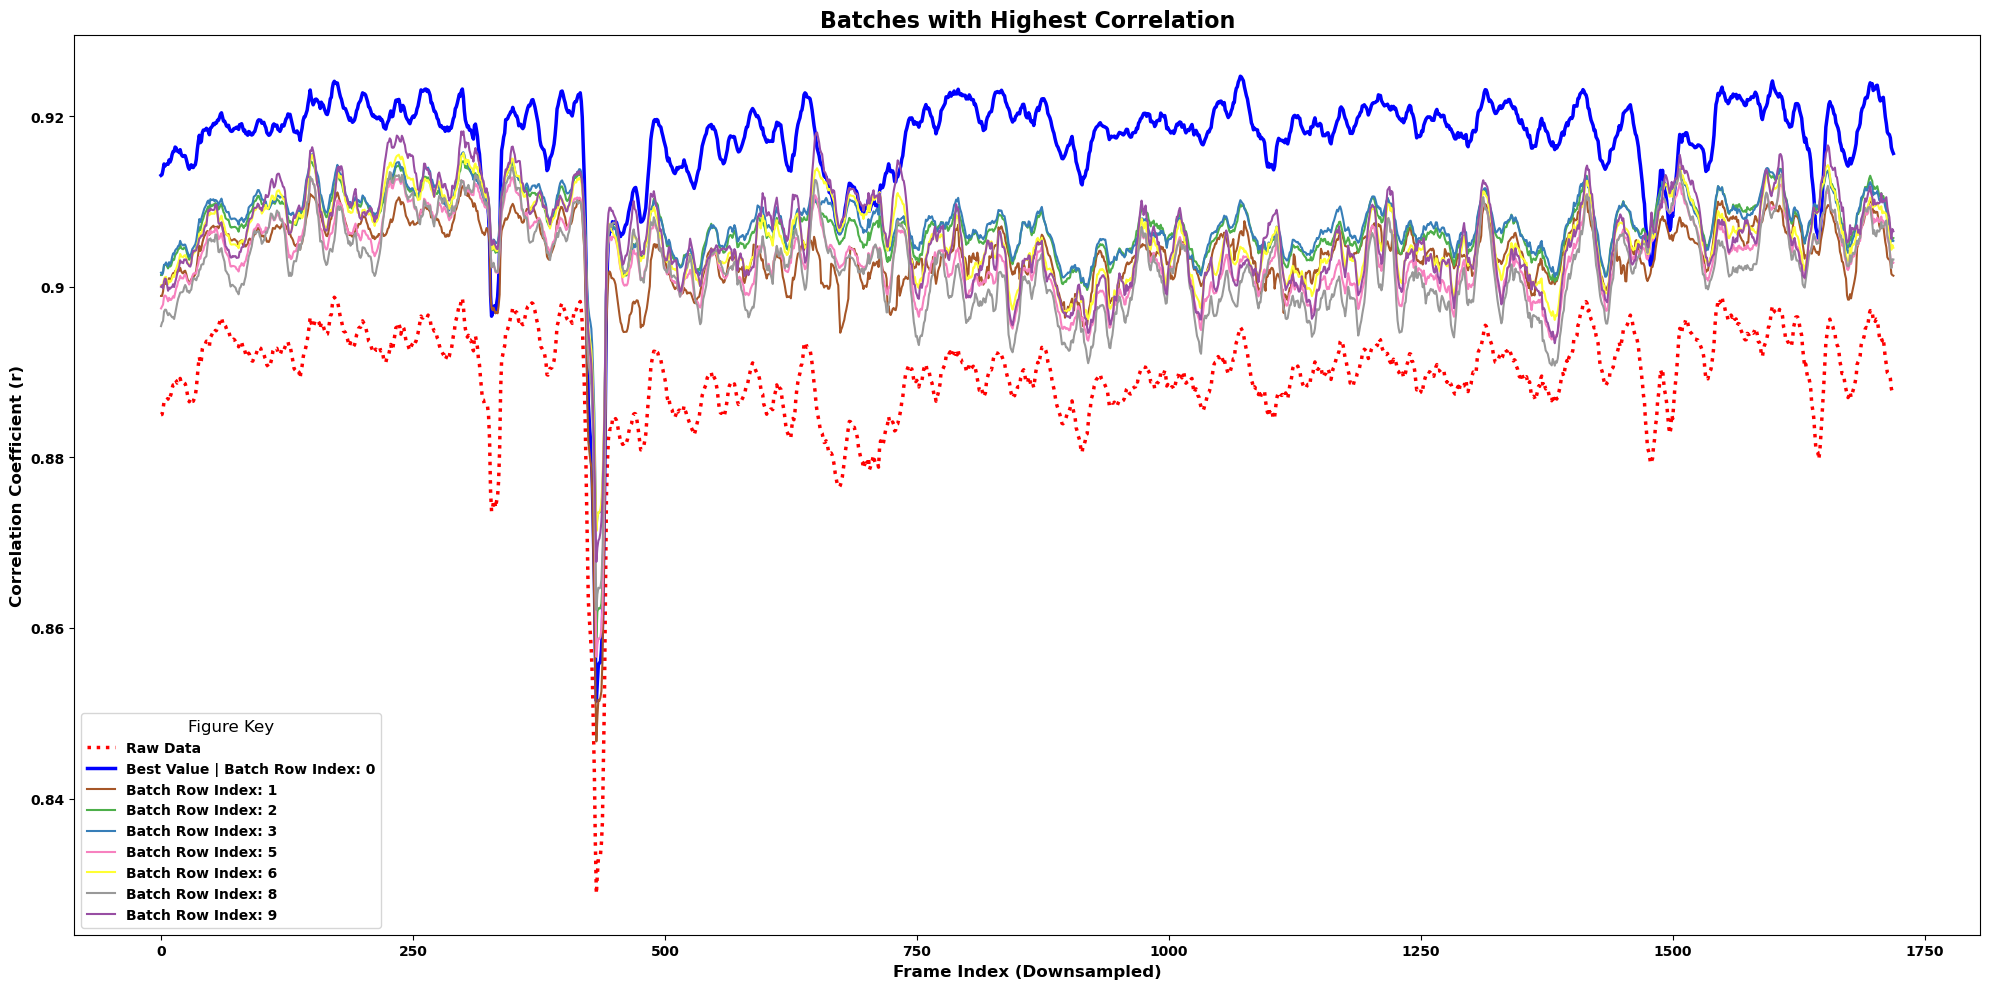

In [22]:
lcp.plot_correlations(results, num_batches=8, smooth=True, winsize=10)

In [23]:
movie_A = df.iloc[0].mcorr.get_output()  # highest correlation
movie_B = df.iloc[2].mcorr.get_output()  # losest optical flow

RFBOutputContext()

JupyterRenderCanvas(css_height='700.0px', css_width='900.0px')
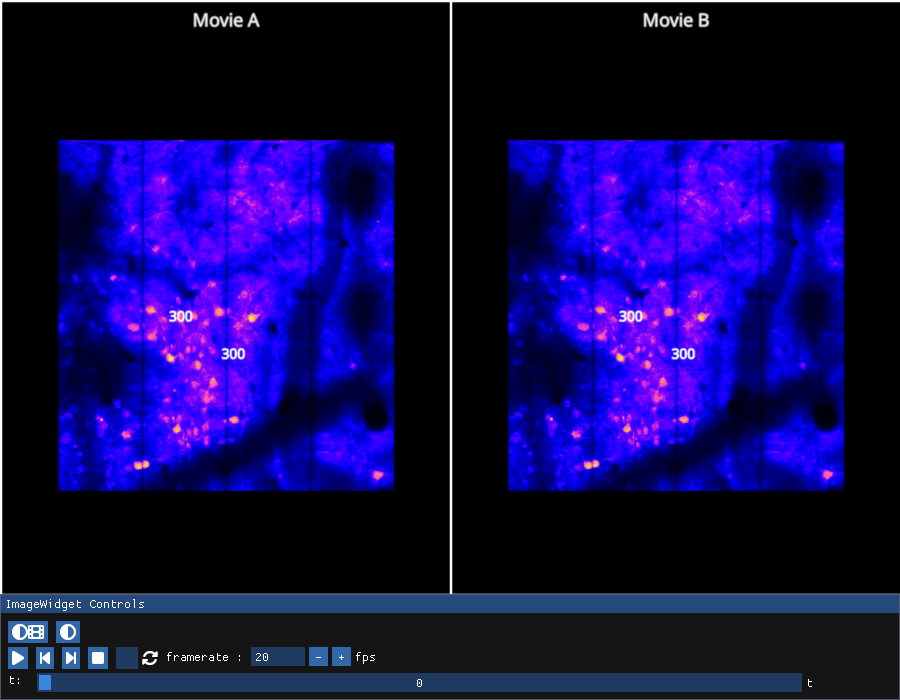

In [30]:
# Change the size/shape depending on how many parameter sweep inputs you used
figure_kwargs={"size": (900, 700), "shape": (1, 2)}

mcorr_iw_multiple = fpl.ImageWidget(
    data=[movie_A, movie_B],  # list of movies
    window_funcs={"t": (np.mean, 7)}, # window functions as a kwarg, this is what the slider was used for in the ready-made viz
    figure_kwargs=figure_kwargs,
    names=['Movie A', 'Movie B'],  # subplot names used for titles
    cmap="gnuplot2"
)

# free up some space
for subplot in mcorr_iw_multiple.figure:
    subplot.docks["right"].size = 0
    subplot.toolbar = False

mcorr_iw_multiple.show()

In [135]:
mcorr_iw_multiple.window_funcs["t"].window_size = 13

In [31]:
mcorr_iw_multiple.close()

## Apply the 'best parameters' to remaining files

When you decide which parameter set works the best, we keep it and delete the other batch items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

```{warning}
On windows, you will get an error `PermissionError: You do not have permissions to remove the output data for the batch item, aborting.` 

This can happen if you forgot to close one of the above widgets, or if you have a memory mapped file open.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

The solution is to restart your kernel. You will need to re-run the cells that define your batch/bath and reload your batch
with df = mc.load_batch(batch_path). Make sure `mc.set_raw_parent_data_path()` is in the re-run cells.
```

In [13]:
# UNCOMMENT THIS TO DELETE BATCH RUNS
# THIS IS COMMENTED OUT SO YOU DONT ACCIDENTALLY DELETE RESULTS YOU HAVE BEEN WAITING FOR ALL NIGHT!!!

rows_keep = [2]
for i, row in df.iterrows():
    if i not in rows_keep:
        df.caiman.remove_item(row.uuid, safe_removal=False)
df

algo item_name         input_movie_path  \
0  mcorr     mcorr  plane_11_assembled.tiff   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   

                                                                                                                   outputs  \
0  {'mean-projection-path': '8d6ff88a-12d4-4029-8b41-064b13d5ff43/8d6ff88a-12d4-4029-8b41-064b13d5ff43_mean_projection....   

            added_time             ran_time algo_duration comments  \
0  2025-01-23T23:46:34  2025-01-24T10:34:48    124.27 sec     None   

                                   uuid  
0  8d6ff88a-12d4-4029-8b41-064b13d5ff43

In [15]:
for i in range(len(tiff_files)):

    # don't re-process the same file
    if tiff_files[i].name == df.iloc[0].input_movie_path:
        continue

    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=tiff_files[i],
        params= df.iloc[0].params,          # use the same parameters
        item_name=f'{tiff_files[i].name}',  # filename of the movie, but can be anything
    )

In [16]:
df.caiman.reload_from_disk()
df.tail()

algo               item_name        input_movie_path  \
54  mcorr  plane_5_assembled.tiff  plane_5_assembled.tiff   
55  mcorr  plane_6_assembled.tiff  plane_6_assembled.tiff   
56  mcorr  plane_7_assembled.tiff  plane_7_assembled.tiff   
57  mcorr  plane_8_assembled.tiff  plane_8_assembled.tiff   
58  mcorr  plane_9_assembled.tiff  plane_9_assembled.tiff   

                                                                                                                     params  \
54  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   
55  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   
56  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   
57  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   
58  {'main': {'pw_rigid': True, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'min_mov': None, 'gSig_fi...   

   outputs           added_time ran_time algo_duration comments  \
54    None  2025-01-24T11:36:38     None          None     None   
55    None  2025-01-24T11:36:38     None          None     None   
56    None  2025-01-24T11:36:38     None          None     None   
57    None  2025-01-24T11:36:38     None          None     None   
58    None  2025-01-24T11:36:38     None          None     None   

                                    uuid  
54  1f5f8773-da41-4475-aa46-3b92fd7bc2e6  
55  0872f10e-8745-45bd-b2b3-6b8560f193a7  
56  0374178f-22e0-4843-bcb9-5e6308b368b1  
57  d519cc68-a4ad-4fad-8c12-0cc2a1c4bc7a  
58  6f5d3d95-5cec-49aa-889a-d4c2194bcdb3

In [ ]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

Running cbdd2903-c3c3-495c-842a-a611cc536ab9 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running e60d2fd3-d8cc-44f3-87fb-bb14ecd661e0 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running f8469e8d-f381-4347-a807-3ffc5e2da32f with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running b42de600-4e8d-4c4c-bfae-633051431809 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 7774bb43-ad40-4240-867a-2c81a0e99eb7 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 9ad445d9-3e08-4547-b61d-c4ebeecff095 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 1777e77c-0529-459c-86a1-64d3bdc01584 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running c57ce669-9380-4c4d-b161-576f970b5b57 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 6df4fcf2-0375-4027-9e9f-bb0a13247877 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
